In [52]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install statsmodel

import pandas as pd
import numpy as np
# import itertools
import warnings
import statsmodels.api as sm

from datetime import datetime, timedelta

# Remove later
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
# import argparse
# import yaml
from sklearn.model_selection import TimeSeriesSplit
# import logging.config
# import boto3
import sys
# import botocore.exceptions as botoexceptions
from datetime import datetime
import os

In [35]:
# from shutil import copyfile

# def train_station_models(df, model_params, optional_fit_args):
"""
Trains a ARIMA model for forecasting inventory for each Citi Bike station that has the necessary data
Args:
    df (pandas DataFrame): input data consisting of confirmed cases globally by day
    model_params (dict): ARIMA model required fit parameters
    optional_fit_args (dict): ARIMA model additional hyperparameters
Returns:
    station_models_df (pandas: ARIMA trained model object
"""

raw_data = pd.read_csv('/Users/Brian/git/423_avc/2021-msia423-lewis-brian-project/data/time_series.csv')

df = raw_data[['station_id', 'date', 'stock']]
# .query('station_id == 72 | station_id == 79')

# get list of each station in the dataset
station_list = df.station_id.unique()

# initial lists to be appended to through training loop
mapes_station_arima = []
stations_w_models =[]
station_models = []

In [36]:
print(len(station_list))

1325


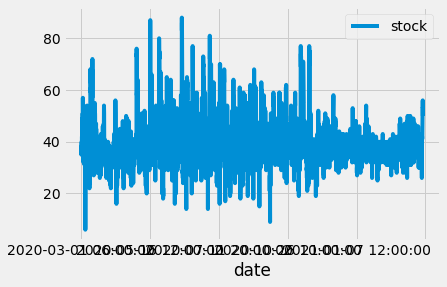

In [16]:
plot_data = df.query('station_id == 72 | station_').drop('station_id', axis = 1)
plot_data.plot()
plt.show()

In [63]:
# Generate forecast time range until August 4 at midnight
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
date_time_list = []
        
start_date = datetime(2021, 4, 1, 0, 00)
end_date = datetime(2021, 8, 4, 0, 00)
for single_date in daterange(start_date, end_date):
    date_time_list.append(single_date.strftime("%Y-%m-%d %H:%M"))
        
len(date_time_list)

3000

In [67]:
# for each station in the list, attempt to build an ARIMA model for forecasting
warnings.filterwarnings("ignore") # specify to ignore warning messages

# df_use = df.query('station_id == 72')
df_use = df

dict_list = []

for station in station_list:

    # subset dataframe to station of interest
    df_train = df_use.loc[df['station_id'] == station]
    df_train.reset_index(inplace=True, drop=True)
    y = df_train['stock']

    # only perform training if there are at least 72 hours (2 weeks) of data with at least 1 bike in that station
    enough_data_flag = len(df_train.loc[df_train['stock'] > 0])
    if enough_data_flag > 72:

        # train on all the data
        arima_def = ARIMA(y, order=(1, 0, 0))
        model_arima = arima_def.fit(
                                          method= 'css-mle',
                                          solver= 'lbfgs',
                                          maxiter= 500,
                                          tol= 1e-08, disp=0
        )
        
        # append model object reference to a list
        stations_w_models.append(station)
        station_models.append(model_arima)

        # for a rough evaluation of each model, train on all but last 6 hours and evaluate on those 
        y_train = y.iloc[0:len(y) - 6]
        y_test = y.iloc[-6:]
        arima_model_eval = ARIMA(y_train, order=(1, 0, 0))
        model_eval_arima_fit = arima_model_eval.fit(
                                                          method= 'css-mle',
                                                          solver= 'lbfgs',
                                                          maxiter= 500,
                                                          tol= 1e-08, disp=0
        )
        
        y_pred = model_eval_arima_fit.forecast(len(y_test))[0]
        mape_result = (abs((y_pred -y_test) / y_test) * 100).mean()
        
        if mape_result > 100:
            mape_result = 100
        else: 
            mape_result = mape_result
        
        mapes_station_arima.append(mape_result)
        
        # Build forecast table
        forecasts = pd.DataFrame(model_arima.forecast(steps = 3000)).transpose()[0]
        
        for i in range(0,3000):
            forecast_d = {'station_id': station, 
                          'date_time': date_time_list[i], 
                          'pred_num_bikes': round(forecasts[i])}
            dict_list.append(forecast_d)
        
    else:
        pass
    
predictions = pd.DataFrame(dict_list)
predictions


,station_id,date_time,pred_num_bikes
0,72,2021-04-01 00:00,49
1,72,2021-04-01 01:00,47
2,72,2021-04-01 02:00,46
3,72,2021-04-01 03:00,45
4,72,2021-04-01 04:00,44
...,...,...,...
3614995,4429,2021-08-03 19:00,20
3614996,4429,2021-08-03 20:00,20
3614997,4429,2021-08-03 21:00,20
3614998,4429,2021-08-03 22:00,20


In [41]:
# create a dataframe consisting of the stations for which a model could be built. In that dataframe have
# station name,
# reference to trained model object, and its approximate MAPE
station_models_df = pd.DataFrame({'Station': stations_w_models,'Model':station_models,'MAPE':mapes_station_arima})
no_model_stations = len(station_list)-len(station_models_df)
# logger.info("Station models trained. Models could not be generated for {} stations due to lack of data.".format(no_model_countries))

output = station_models_df

In [42]:
print(len(stations_w_models))
print(len(station_models))
print(len(mapes_station_arima))

1289
1289
1289


In [34]:
output

,Station,Model,MAPE
0,72,<statsmodels.tsa.arima_model.ARMAResultsWrappe...,12.995392
1,79,<statsmodels.tsa.arima_model.ARMAResultsWrappe...,36.588195
